Het eerste deel is een kopie van Fons zijn Input

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import ipywidgets
from IPython.display import display, clear_output, Javascript, Markdown

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [8, 4]

In [2]:
def subdirectories_of(path):
    return [item.resolve() for item in path.iterdir() if item.is_dir()]


current_path = Path().resolve()
git_path = current_path

# While we are not at the root of the git directory:
while not '.git' in map(lambda p: p.name, subdirectories_of(git_path)):
    # Move one directory up, and check again
    git_path = git_path.parent.resolve()
    if len(git_path.parts) <= 1:
        raise Warning("This script is not running in the git repository. Configure data path manually.")


data_path = git_path / "data" / "origineel"
print("Git root path found at: "+str(git_path))
print("Using data path:        " + str(data_path))

if not Path(data_path).is_dir():
    raise Warning("Data path does not exist")

Git root path found at: C:\Users\sebas\Documents\GitHub\SCG-analyse
Using data path:        C:\Users\sebas\Documents\GitHub\SCG-analyse\data\origineel


In [3]:
# Lijst van .csv-bestanden
data_file_paths = list(data_path.glob("*.csv"))

if len(data_file_paths) == 0:
    raise Warning("No .csv files found in " + str(data_path) + "; Note that data files are not stored in this repository, and must be downloaded manually.")


# Geef het circuitnummer (4 cijfers) dat in de naam van een Path staat
circuitnum_from_file_path = lambda file_path: int(file_path.name.split('-')[0])

# Drie dictionaries, met als keys de circuitnummers (int), als value de Pandas DataFrame van de .csv.
cable_config       = {circuitnum_from_file_path(fp): pd.read_csv(fp, sep=";") for fp in data_file_paths if 'cableconfig' in fp.name}
partial_discharges = {circuitnum_from_file_path(fp): pd.read_csv(fp, sep=";") for fp in data_file_paths if 'pd' in fp.name}
warning            = {circuitnum_from_file_path(fp): pd.read_csv(fp, sep=";") for fp in data_file_paths if 'warning' in fp.name}

# Sla de keys op van alle kabels waarvoor PD data bestaat.
circuits = list(partial_discharges)

print("Cable config loaded for circuits:", list(cable_config))
print("   PD series loaded for circuits:", list(partial_discharges))
print("Warning logs loaded for circuits:", list(warning))

Cable config loaded for circuits: [1512, 2063, 2145, 2806, 2870, 2979, 2980, 3010]
   PD series loaded for circuits: [1512, 2063, 2145, 2806, 2870, 2979, 2980, 3010]
Warning logs loaded for circuits: [1512, 2063, 2145, 2806, 2870]


In [4]:
# Standaardkeuze:
circ = circuits[1]

In [5]:
def update_fig(event):
    global circ
    if event.name == 'value':
        circ = event.new
        # Gebruik deze 'hack' om alle cellen onder de huidige opnieuw te runnen
        display(Javascript("IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1,IPython.notebook.get_cells().length)"))


circuit_chooser = ipywidgets.Dropdown(options=circuits,
                                      value=circ,
                                      description='Circuit:',
                                      disabled=False)
circuit_chooser.observe(update_fig)

display(Markdown("-----------"))
display(Markdown("# Kies een circuit:"))
display(circuit_chooser)
display(Markdown("-----------"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-----------

# Kies een circuit:

Dropdown(description='Circuit:', index=1, options=(1512, 2063, 2145, 2806, 2870, 2979, 2980, 3010), value=2063…

-----------

In [6]:
# Lengte van de kabel is gegeven in de cable config
cable_length = cable_config[circ]['Cumulative length (m)'].values[-1]


pd_raw = partial_discharges[circ]
# Sla de drie kolomnamen van PD voor het gemak op
date, location, charge = pd_raw.columns
pd = pd_raw.dropna(subset=[charge])
print(pd.head())




          Date/time (UTC)  Location in meters (m)  Charge (picocoulomb)
382   2017-08-22 00:25:00                0.000000               25141.5
1111  2017-08-22 18:24:00             1869.181579               19401.5
1229  2017-08-22 21:20:00             1424.902004               14303.0
1290  2017-08-22 22:35:00              235.358102               28000.0
1331  2017-08-22 23:32:00             1524.610363               20693.5


In [7]:

# use_threshold = True
# if(use_threshold):
#     pd = pd[ pd.charge > threshold ]
# # De drie kolommen; alleen op tijdstippen met PD
# locations = pd_thresh[location]
# charges = pd_thresh[charge]
# times = pd_thresh[date].apply(lambda date_string: datetime.datetime.strptime(date_string, "%Y-%m-%d %H:%M:%S"))
# charges

# pd[5:12]
# print(pd.iloc[5].date)
# print(pd.date.loc[382])


We hebben nu een pandas dataframe pd waarbij we de momenten zonder partial discharge hebben verwijderd.

In [8]:
locations, dates, charges = pd[location], pd[date].apply(datetime.datetime.fromisoformat), pd[charge]

In [9]:
print(locations.head())
print(dates.head())

382        0.000000
1111    1869.181579
1229    1424.902004
1290     235.358102
1331    1524.610363
Name: Location in meters (m), dtype: float64
382    2017-08-22 00:25:00
1111   2017-08-22 18:24:00
1229   2017-08-22 21:20:00
1290   2017-08-22 22:35:00
1331   2017-08-22 23:32:00
Name: Date/time (UTC), dtype: datetime64[ns]


<IPython.core.display.Javascript object>


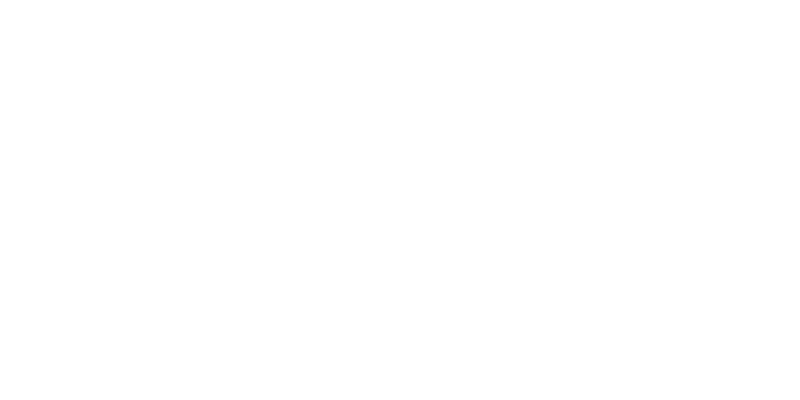

In [10]:
%matplotlib notebook

fig,ax = plt.subplots()

ax.scatter(x=locations, y=dates, s=charges/1e4, c='.0')
#ax.set_xlabel("Location")
#ax.set_ylabel("Date")

#ax.set_title("Circuit {0}".format(circ))
fig.show()


In [11]:
############ PARAMETERS ############

bin_size = 2.0 # meter
count_charges = False

####################################

bins = np.arange(start=0., stop=cable_length, step=bin_size)
# Tel inhoud van elk bakje:

binned_pds, _ = np.histogram(locations, bins=bins, weights=charges if count_charges else None)

Hieronder staan gewoon de normale histogrammen zonder drempel

<IPython.core.display.Javascript object>


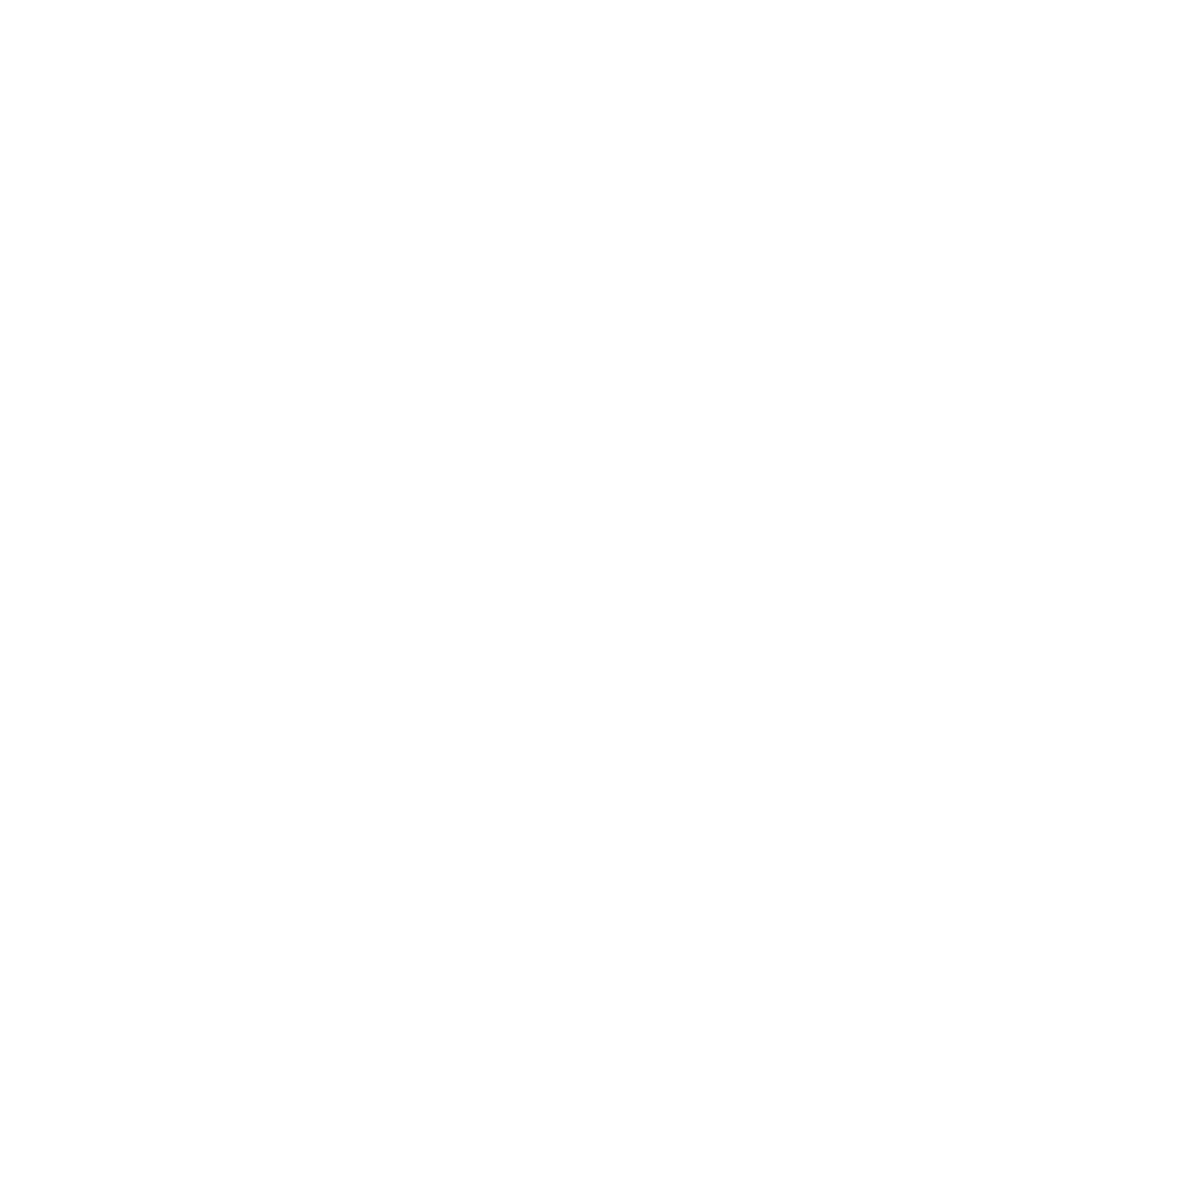

In [12]:
fig,ax = plt.subplots(2,1,figsize=(12,12))

ax1,ax2 = ax

ax1.hist(locations,bins=bins,color='0')
ax1.set_xlabel("Location (m)")
ax1.set_ylabel("Number of PDs")

ax2.hist(locations,bins=bins, weights=charges,color='0')
ax2.set_xlabel("Location (m)")
ax2.set_ylabel("Cumulative charge (pC)")

fig.show()

Hieronder zijn we weer terug bij af. Ik ga experimenteren met drempels en met density plots

In [13]:
############ PARAMETERS ############

bin_size = 5.0 # meter
count_charges = False
densitybool = True
threshold = 100000

####################################
pd_thresh = pd[pd[charge]>threshold]

locationsth, datesth, chargesth = pd_thresh[location], pd_thresh[date].apply(datetime.datetime.fromisoformat), pd_thresh[charge]
bins = int(cable_length/bin_size)


In [14]:
# def plot_histogram(locations):
#     %matplotlib notebook

#     fig,ax = plt.subplots()

#     ax.hist(locations,density=densitybool, bins=bins, weights=chargesth if count_charges else None, color='0')
#     ax.set_xlabel("Location (m)")
#     ax.set_ylabel("Number of PDs")
#     ax.set_title("Histogram van circuit {0}".format(circ)+" met emmers van "+str(bin_size) +" meter en een drempel van "+str(threshold))

#     fig.show()

<IPython.core.display.Javascript object>


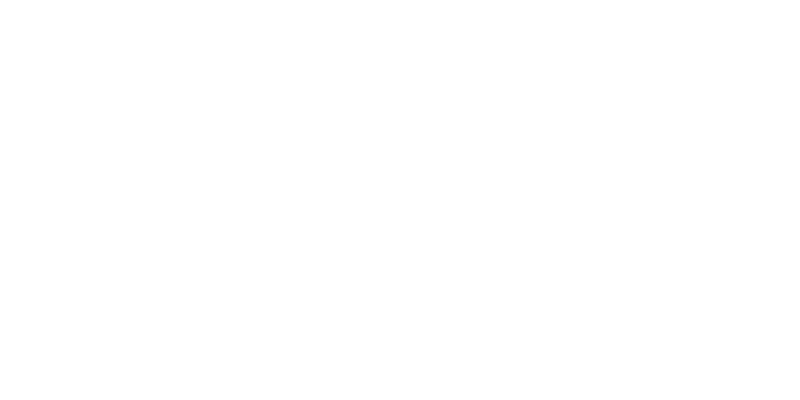

In [15]:
%matplotlib notebook

fig,ax = plt.subplots()

ax.hist(locationsth,density=densitybool, bins=bins, weights=chargesth if count_charges else None, color='0')
ax.set_xlabel("Location (m)")
ax.set_ylabel("Number of PDs")
ax.set_title("Histogram van circuit {0}".format(circ)+" met emmers van "+str(bin_size) +" meter en een drempel van "+str(threshold))

fig.show()

Ik wil hieronder de verdeling van de charges plotten om een idee te krijgen.

<IPython.core.display.Javascript object>


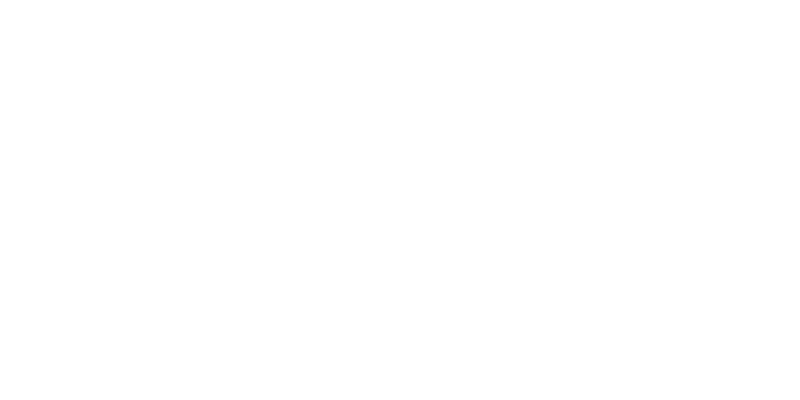

In [16]:
%matplotlib notebook

fig,ax = plt.subplots()

ax.hist(charges, density=True, bins=1000, color='0')
ax.set_xlabel("Charge (picocoulomb)")
ax.set_ylabel("Relative number of PDs")
ax.set_title("Circuit {0}".format(circ)+": dichtheidsfunctie charges")
fig.show()

Hieronder bekijk ik de dichtheden van de histogrammen. In andere woorden ik kijk hoe het aantal pds per emmertje verdeeld is.

In [17]:
count_charges = False

<IPython.core.display.Javascript object>


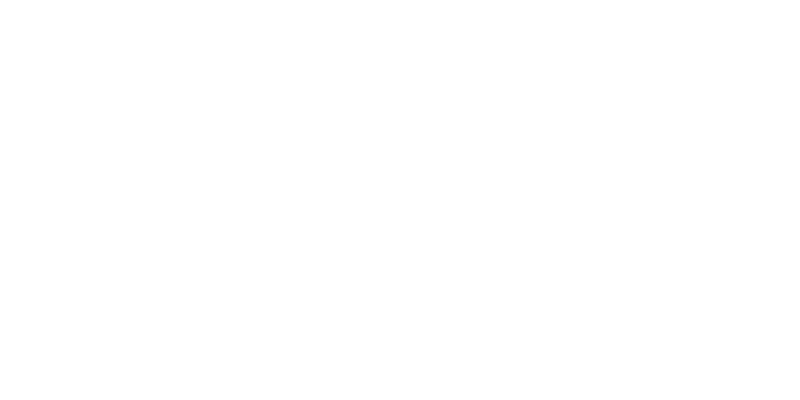

In [18]:
def histofhist(locations, bins, charges, count_charges):
    %matplotlib notebook

    fig,ax = plt.subplots()
    binned_pds, _ = np.histogram(locations, bins=bins, weights=charges if count_charges else None)
    ax.hist(binned_pds, density=False, bins=1000, color='0')
    ax.set_xlabel("Number of pds per bin")
    ax.set_ylabel("Number of bins")
    ax.set_title("Circuit {0}".format(circ)+": Hoeveelheid bins met bepaalde hoeveelheid pds per bin")

    fig.show()
histofhist(locations, bins, charges, count_charges)

Ik kijk hieronder naar het aantal pds per dag en wellicht per week.

In [19]:
############
#parameters voor tellen pds per dag
densitybool = False
count_charges = False
print(dates.iloc[0])
print(dates.iloc[-1])
print((dates.iloc[-1]-dates.iloc[0]).days)
bins = (dates.iloc[-1]-dates.iloc[0]).days
#pandas.date_range(start=dates.iloc[0], end=dates.iloc[-1], periods=bins,)

2017-08-22 00:25:00
2018-11-13 06:35:00
448


<IPython.core.display.Javascript object>


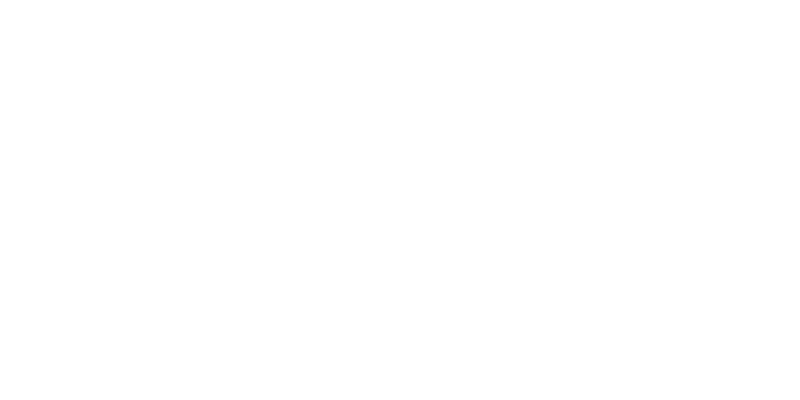

In [20]:
%matplotlib notebook

fig,ax = plt.subplots()

ax.hist(dates,density=False, bins=bins, weights=charges if count_charges else None, color='0', orientation='horizontal')
ax.set_ylabel("Date")
ax.set_xlabel("Number of PDs")
ax.set_title("Histogram van circuit {0}".format(circ)+" met emmers van dagen")
fig.show()

Ik wil kijken of het handig is om te kijken naar de charges bij het bepalen van de verschillende

<IPython.core.display.Javascript object>


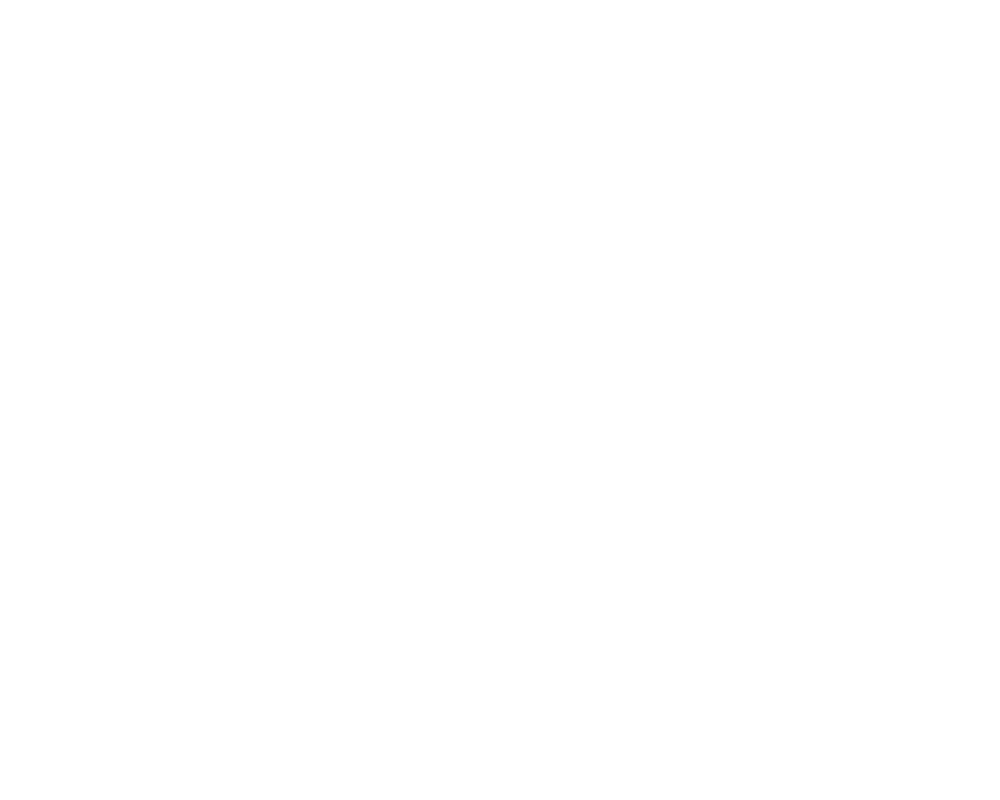

In [21]:
%matplotlib notebook

fig,ax = plt.subplots(2,1,figsize=(10,8))

ax1,ax2 = ax

ax1.hist(dates,density=True, bins=bins, color='0')
ax1.set_xlabel("Date")
ax1.set_ylabel("Relative number of PDs")
ax1.set_title("Circuit {0}".format(circ)+": Relatieve hoeveelheid pds per dag vs cumulatieve charges")

ax2.hist(dates,density=True, bins=bins, weights=charges, color='0')
ax2.set_xlabel("Date")
ax2.set_ylabel("Relative cumulative charge")

fig.show()

<IPython.core.display.Javascript object>


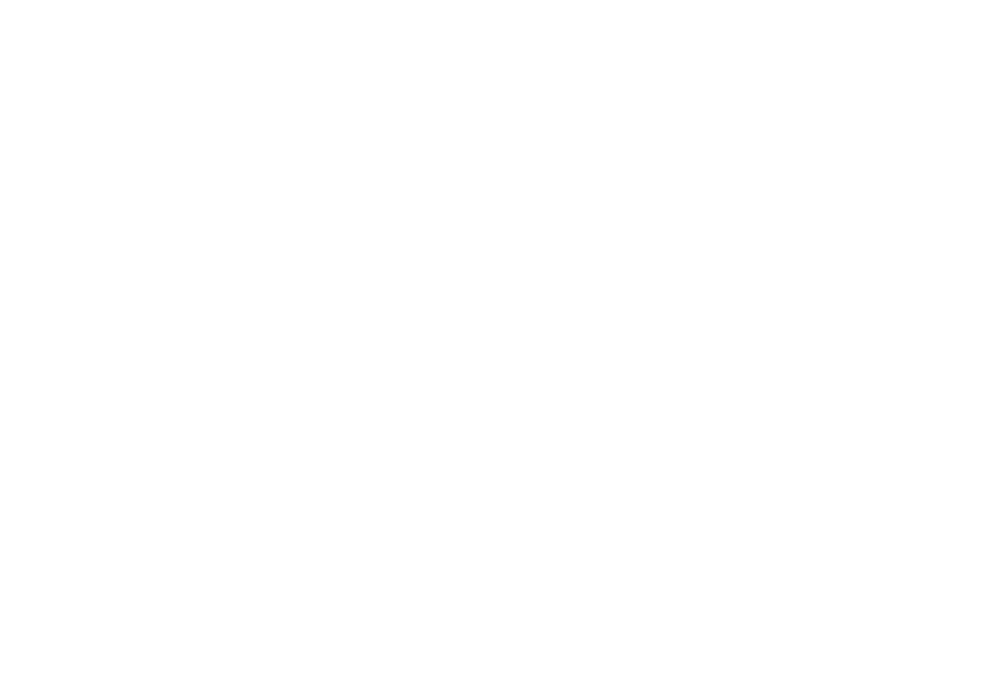

In [22]:
%matplotlib notebook

fig,ax = plt.subplots(2,1,figsize=(10,7))

ax2,ax1 = ax

ax1.hist(dates,density=False, bins=bins, weights=charges if count_charges else None, color='0', orientation='vertical')
ax1.set_xlabel("Date")
ax1.set_ylabel("Number of PDs")

# ax2.hist(locations,bins=bins, weights=charges,color='0')
# ax2.set_xlabel("Location (m)")
# ax2.set_ylabel("Cumulative charge (pC)")
ax2.scatter(x=dates, y=locations, s=charges/1e4, c='.0')
ax2.set_xlabel("Location")
ax2.set_title("Scatterplot + histogram van circuit {0}".format(circ)+" voor de verdeling van de pds over de tijd")

fig.show()

<IPython.core.display.Javascript object>


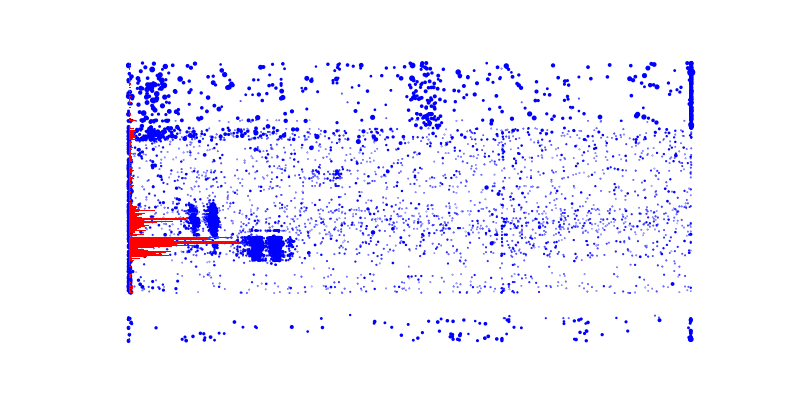

In [23]:
%matplotlib notebook

fig,ax = plt.subplots()


ax.hist(dates,density=False, bins=bins, weights=charges if count_charges else None, color='red', orientation='horizontal')
# ax.set_xlabel("Date")
ax.set_ylabel("Date")
ax.set_title("Histogram van circuit {0}".format(circ)+" met emmers van dagen")

ax.scatter(x=locations, y=dates, s=charges/1e4,color='blue')

# ax2.set_xlabel("Location")
# ax2.set_ylabel("Date")
# ax2.set_title("Circuit {0}".format(circ))

fig.show()